# Step 5: Find matches within a search radius

In [1]:
from functools import partial
import numpy as np
import os
from phathom.utils import pickle_load, read_voxel_size
from phathom.registration.coarse import rigid_transformation
from phathom.registration.pcloud import radius_matching, rotation_matrix
from phathom import plotting

In [2]:
working_dir = '/media/jswaney/Drive/Justin/marmoset'

In [3]:
# Load blobs
fixed_blobs_path = 'round1/blobs.npy'
moving_blobs_path = 'round2/blobs.npy'

fixed_blobs = np.load(os.path.join(working_dir, 
                                   fixed_blobs_path))
moving_blobs = np.load(os.path.join(working_dir, 
                                    moving_blobs_path))
print('keypoints:', fixed_blobs.shape, moving_blobs.shape)

keypoints: (27449319, 3) (27572651, 3)


In [4]:
# Load features
fixed_features_path = 'round1/features.npy'
moving_features_path = 'round2/features.npy'

fixed_feat = np.load(os.path.join(working_dir, 
                                  fixed_features_path))
moving_feat = np.load(os.path.join(working_dir, 
                                   moving_features_path))
print('features:', fixed_feat.shape, moving_feat.shape)

features: (27449319, 6) (27572651, 6)


In [5]:
# Load the rigid transformation
transformation_path = 'rigid_transformation.pkl'

transformation_dict = pickle_load(os.path.join(working_dir, 
                                               transformation_path))
t = transformation_dict['t']
center = transformation_dict['center']
theta = transformation_dict['theta']
s = transformation_dict['s']
print('Loaded rigid transformation for original image')
print('Rotation (deg):', theta*180/np.pi)
print('Center (px):', center)
print('Translation (px):', t)
print('Scale Factor:', s)

Loaded rigid transformation for original image
Rotation (deg): [-32.22211118  14.03567903  -4.33941505]
Center (px): [ 2018.60540501  4194.25275517  2923.68065906]
Translation (px): [ 127.38498407  321.40539529 -904.1310784 ]
Scale Factor: 1.01388723289


In [6]:
# Roghly align fixed_pts
r = rotation_matrix(theta)
transformation = partial(rigid_transformation, t=t, r=r, center=center, s=s)
transformed_pts = transformation(pts=fixed_blobs)
transformed_pts.shape

(27449319, 3)

In [7]:
# Save coarse aligned pts
np.save(os.path.join(working_dir, 'round1/blobs_coarse.npy'), transformed_pts)

In [7]:
# Convert to micron
voxel_size_path = 'voxel_size.csv'

voxel_size = read_voxel_size(os.path.join(working_dir, voxel_size_path))
voxel_size

(2.0, 1.8, 1.8)

In [8]:
transformed_pts_um = np.asarray(voxel_size) * transformed_pts
moving_pts_um = np.asarray(voxel_size) * moving_blobs

<IPython.core.display.Javascript object>


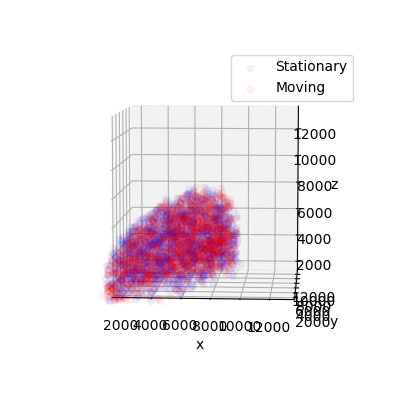

In [9]:
%matplotlib notebook
nb_pts = 2000

moving_idx = np.arange(moving_blobs.shape[0])
np.random.shuffle(moving_idx)
transformed_idx = np.arange(transformed_pts.shape[0])
np.random.shuffle(transformed_idx)

plotting.plot_pts(moving_pts_um[moving_idx[:nb_pts]], transformed_pts_um[transformed_idx[:nb_pts]], alpha=0.05)

In [12]:
# Match to moving_pts within search radius
radius = 150
nb_workers = None
batch_size = 500000
matching_kwargs = {'max_fdist': 2,
                   'prom_thresh': 0.3}

idx_fixed, idx_moving = radius_matching(transformed_pts_um, 
                                        moving_pts_um, 
                                        fixed_feat, 
                                        moving_feat, 
                                        radius, 
                                        nb_workers, 
                                        batch_size, 
                                        matching_kwargs)
print('Found {} matches'.format(idx_fixed.shape[0]))

Found 52704 matches


In [13]:
# Save matching indices
fixed_idx_path = 'round1/match_idx.npy'
moving_idx_path = 'round2/match_idx.npy'

np.save(os.path.join(working_dir, fixed_idx_path), idx_fixed)
np.save(os.path.join(working_dir, moving_idx_path), idx_moving)